In [1]:
#add here your imports
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import seaborn as sns

In [2]:
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# load data
PATH_TO_DATA = os.path.join("data","dow_jones_index.data")
data_original = pd.read_csv(PATH_TO_DATA)
data = data_original
#add here your data understanting code


In [4]:
# converting money variables to floats
money_variables = ['open','high','low','close','next_weeks_open','next_weeks_close']

for v in money_variables:
    data[v]=data[v].str[1:].astype(float)
    
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data['stock']= data['stock'].astype('category')

In [5]:
# Dealing with target leakage

# We do not include "next_weeks_open" as when we decide to buy we can see the current price of the stocks.
# Since we are not told when the decision must be made I am assuming it is made as soon as the next week starts
future_columns = ["next_weeks_close","percent_change_next_weeks_price", "percent_return_next_dividend"]

Y = data[["stock","percent_change_next_weeks_price"]]
data= data.drop(columns=future_columns)

In [6]:
data.isna().sum()

quarter                                0
stock                                  0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
days_to_next_dividend                  0
dtype: int64

In [7]:
# drop NAN columns
data = data.dropna(axis=1)

In [8]:
data.head()

,quarter,stock,open,high,low,close,volume,percent_change_price,next_weeks_open,days_to_next_dividend
date,,,,,,,,,,
2011-01-07,1,AA,15.82,16.72,15.78,16.42,239655616,3.79267,16.71,26
2011-01-14,1,AA,16.71,16.71,15.64,15.97,242963398,-4.42849,16.19,19
2011-01-21,1,AA,16.19,16.38,15.60,15.79,138428495,-2.47066,15.87,12
2011-01-28,1,AA,15.87,16.63,15.82,16.13,151379173,1.63831,16.18,5
2011-02-04,1,AA,16.18,17.39,16.18,17.14,154387761,5.93325,17.33,97


In [9]:
data.tail()

,quarter,stock,open,high,low,close,volume,percent_change_price,next_weeks_open,days_to_next_dividend
date,,,,,,,,,,
2011-05-27,2,XOM,80.22,82.63,80.07,82.63,68230855,3.00424,83.28,75
2011-06-03,2,XOM,83.28,83.75,80.18,81.18,78616295,-2.52161,80.93,68
2011-06-10,2,XOM,80.93,81.87,79.72,79.78,92380844,-1.42098,80.00,61
2011-06-17,2,XOM,80.00,80.82,78.33,79.02,100521400,-1.22500,78.65,54
2011-06-24,2,XOM,78.65,81.12,76.78,76.78,118679791,-2.37762,76.88,47


In [10]:
data.dtypes

quarter                     int64
stock                    category
open                      float64
high                      float64
low                       float64
close                     float64
volume                      int64
percent_change_price      float64
next_weeks_open           float64
days_to_next_dividend       int64
dtype: object

In [11]:
data.describe(include='all')

,quarter,stock,open,high,low,close,volume,percent_change_price,next_weeks_open,days_to_next_dividend
count,750.000000,750,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,750.000000,750.000000
unique,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.520000,NaN,53.651840,54.669987,52.640160,53.729267,1.175478e+08,0.050262,53.702440,52.525333
std,0.499933,NaN,32.638852,33.215994,32.119277,32.788787,1.584381e+08,2.517809,32.778111,46.335098
min,1.000000,NaN,10.590000,10.940000,10.400000,10.520000,9.718851e+06,-15.422900,10.520000,0.000000
25%,1.000000,NaN,29.830000,30.627500,28.720000,30.365000,3.086624e+07,-1.288053,30.315000,24.000000
50%,2.000000,NaN,45.970000,46.885000,44.800000,45.930000,5.306088e+07,0.000000,46.015000,47.000000
75%,2.000000,NaN,72.715000,74.287500,71.037500,72.667500,1.327218e+08,1.650888,72.715000,69.000000


In [12]:
numeric_features = data.select_dtypes(include=np.number).columns.tolist()
categorical_features = data.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline([
    ('scaler', StandardScaler(with_mean=False))])# normalize data, mean=false as X is sparse

#categorical_transformer = Pipeline(())# one hot encoding of categorical data

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)], remainder='passthrough')

In [13]:
# divide data by company

data_by_stock = {}
stock_list = []
for stock, d in data.groupby('stock'):
    stock_list.append(stock)
    d=d.drop(columns='stock')
    data_by_stock[stock] = d
Y_list = {}
for stock, d in Y.groupby('stock'):
    Y_list[stock] = d["percent_change_next_weeks_price"]

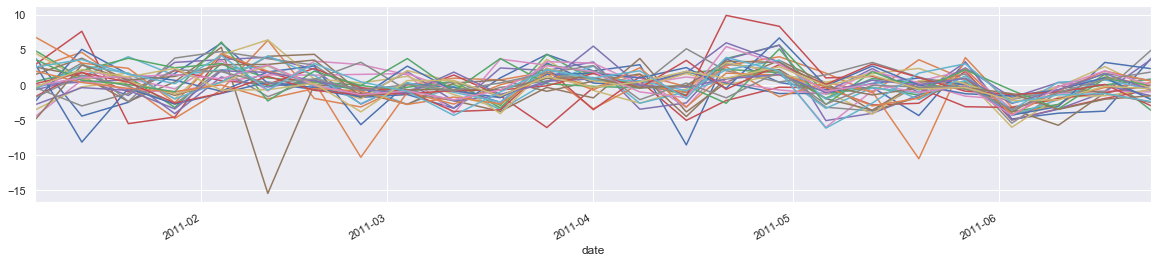

In [14]:
sns.set(rc={'figure.figsize':(20, 4)})

for stock in stock_list:
   data_by_stock[stock]['percent_change_price'].plot()

In [15]:
svr_pipeline = {}
for stock in stock_list:
    svr_pipeline[stock] = Pipeline([
    #('preprocessor', preprocessor), 
    ('clf', SVR(C=1.0, epsilon=0.2))])
for stock in stock_list:
    svr_pipeline[stock].fit(data_by_stock[stock],Y_list[stock])

In [16]:
ans = {}
for stock in stock_list:
    ans[stock]=svr_pipeline[stock].predict(data_by_stock[stock])

In [17]:
ans['AA']

array([-0.74899354, -0.79332811, -0.01334369,  0.02792719,  0.03057099,
       -0.20220575, -0.64147687, -0.04461208, -0.25939787, -0.20600097,
       -0.06232054, -0.43171669, -0.33277445, -0.07057678, -0.39074388,
       -0.57018933, -0.49436091, -0.54989295, -0.2353224 , -0.16556521,
       -0.67959374, -0.68074161, -0.43932388, -0.23929289, -0.38161741])

In [18]:
from sklearn.metrics import mean_squared_error

for stock in stock_list:
    print(mean_squared_error(Y_list[stock], ans[stock]))

13.367175711850516
8.91664955081513
6.142954858595227
10.200874552134607
12.400394116501817
16.153065547024344
7.7176111185638385
7.725465162755963
8.018764099446486
6.032420810267731
6.0659627248854315
13.25988692313365
3.618421957536956
12.0723264309528
4.3667878487257425
6.575740088627635
2.93997628428043
3.015934963084478
3.347703414294374
5.108166324064138
6.64698157119928
5.736487926499794
5.975417922292603
3.0458379181500437
3.2869381935886537
3.740431029346036
6.011796175826919
3.5221127082493116
2.3468789952668003
8.528630383862243
